In [1]:
# Library imports (see install section in the readme).
import sys
import networkx as nx
import csv
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
from pyproj import Transformer
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
import osmnx as ox
import time
import matplotlib.lines as mlines
from IPython.display import IFrame
import pickle
import math
import seaborn as sns
import copy
import folium
import matplotlib.ticker as mtick
import random
sns.set_style("whitegrid")
%matplotlib inline

In [2]:
# Fixed arguments.
#  1. File path where the original network is stored.
graph_path = "Girona_City_Sewer_V5.graphml"

#  2. File path where the trees are defined.
tree_path = "Girona_Trees_2022_Up_2023.csv"
#  3. Input coordinate systems.
input_coordinates = "epsg:25831"
output_coordinates = "epsg:4326"
meter_coordinates = "epsg:3857"

In [3]:
# Function that filters the tree data.
def filter_data(data):
    data = str(data)
    if not data or data == '' or data == 'nan':
        # From the literature, the average size of a medium-sized tree trunk diameter is from 15 to 19 inches.
        data = '43'
    elif "-" in data:
        diam_list = [int(element) for element in data.split("-")]
        data = str(round(sum(diam_list) / len(diam_list)))
    data = data.replace('<','')
    data = data.replace('>','')
    return data

In [4]:
# Dictionary of "sewer-safe" trees (see manuscript for more info).
safe_trees_list = ["acer ginnala","acer griseum","acer palmatum","amelanchier","carpinus betulus","cercis canadensis","chionanthus","cornus florida","cornus kousa","cotinus","crataegus viridis","fagus sylvatica","ginkgo biloba","gleditsia triacanthos","ilex x attenuata","koelreuteria paniculata","lagerstroemia","magnolia grandiflora","magnolia x soulangiana","malus","oxydendron arboreum","prunus caroliniana"]

# Function that obtains the TPZ given a tree scientific name and trunk diameter size (from literature: Day et al. method).
def get_tpz_day(tree_name, trunk_diameter):
    if any(substring in tree_name.lower() for substring in safe_trees_list):
        return 6 * (trunk_diameter/100)
    else:
        return 18 * (trunk_diameter/100)

# Function that obtains the TPZ given trunk size (Australian standard).
def get_tpz_as(trunk_diameter):
    return 12 * (trunk_diameter/100)

# Function that obtains the TPZ given trunk size (best case: all ``sewer-safe'').
def get_tpz_sewersafe(trunk_diameter):
    return 6 * (trunk_diameter/100)

# Get the mean value of trunk diameter from an interval of trunk perimeter.
def get_mean_tronc(interval_trunk_perimeter):
    perimeter = str(interval_trunk_perimeter)
    if not perimeter or perimeter == '' or perimeter == 'nan':
        # Suppose mean value between 20 and 160: 90.
        perimeter = 90
    elif "-" in perimeter:
        perimeter_list = [int(element) for element in perimeter.split("-")]
        perimeter = round(sum(perimeter_list) / len(perimeter_list))
    elif perimeter == ">120":
        # Suppose mean value between 120 and 160: 140.
        perimeter = 140
    else:
        print('ALERT! Unidentified value:',perimeter)
    return perimeter / math.pi

# Get the max value of trunk diameter from an interval of trunk perimeter.
def get_max_tronc(interval_trunk_perimeter):
    perimeter = str(interval_trunk_perimeter)
    if not perimeter or perimeter == '' or perimeter == 'nan':
        # Suppose max value between 20 and 160: 160.
        perimeter = 160
    elif "-" in perimeter:
        perimeter_list = [int(element) for element in perimeter.split("-")]
        perimeter = perimeter_list[len(perimeter_list)-1]
    elif perimeter == ">120":
        # Suppose max value between 120 and 160: 160.
        perimeter = 160
    else:
        print('ALERT! Unidentified value:',perimeter)
    return perimeter / math.pi
        

In [5]:
# Function that prints a network.
color_palette = ["#0096FF", "#7ddc1f", "#ffa500", "#ff2500"]

def print_network(graph, edge_risks, risk_dict, tree_geo = [], filename = None):
    
    g_attr = graph.copy()

    # Compute colors for route from WWTP to water tanks
    edge_colors = []
    edge_linewidth = []
    for u, v, data in g_attr.edges(data = True):
        edge_colors.append(color_palette[edge_risks[data['id']]])
        edge_linewidth.append(1)

    fig, base = ox.plot_graph(g_attr, bgcolor='white', figsize=(25, 25), show=False, close=False, 
                              edge_color=edge_colors, node_edgecolor='#9c9c9c', node_size=0, 
                              edge_linewidth=edge_linewidth)
    
    # Prepare LEGEND
    n_pipes = len(graph.edges()) 
    handles, labels = base.get_legend_handles_labels()
    handles.append(mlines.Line2D([0], [0], color='white', marker='s', markersize=15, markerfacecolor=color_palette[0], 
                                 label='Non-existent Risk ('+str(round(risk_dict[0]/n_pipes*100,2))+'% of pipes)'))
    handles.append(mlines.Line2D([0], [0], color='white', marker='s', markersize=15, markerfacecolor=color_palette[1], 
                                 label='Low Risk ('+str(round(risk_dict[1]/n_pipes*100,2))+'% of pipes)'))
    handles.append(mlines.Line2D([0], [0], color='white', marker='s', markersize=15, markerfacecolor=color_palette[2], 
                                 label='Moderate Risk ('+str(round(risk_dict[2]/n_pipes*100,2))+'% of pipes)'))
    handles.append(mlines.Line2D([0], [0], color='white', marker='s', markersize=15, markerfacecolor=color_palette[3], 
                                 label='High Risk ('+str(round(risk_dict[3]/n_pipes*100,2))+'% of pipes)'))
    
    for tree in tree_geo: 
        base.scatter(tree[1], tree[0], c='#000000', s=300, marker='.', zorder=-1)
    plt.legend(handles=handles, loc="upper left", prop={'size': 18})
    
    plt.show()
    if filename != None:
        fig.savefig('./pdfs/'+filename + '.pdf', format="PDF", bbox_inches='tight')

In [6]:
#####################################
############ CODE BEGINS ############ 
#####################################

# Read the graph
graph = nx.read_graphml(graph_path)

# Read tree CSV file into a dataframe.
df = pd.read_csv(tree_path, delimiter=';', skiprows=0, low_memory=False)
df['nom_cientific'] = df['nom_cientific'].apply(lambda x: 'Especie desconeguda' if (not x or x == '' or x == np.nan) else x)
df['nom_cientific'] = df['nom_cientific'].replace(np.nan, 'Especie desconeguda')
df['nom'] = df['nom'].apply(lambda x: 'Especie desconeguda' if (not x or x == '' or x == np.nan) else x)
df['nom'] = df['nom'].replace(np.nan, 'Especie desconeguda')

# Convert input coordinates into GPS and meter systems.
t = Transformer.from_crs(input_coordinates, output_coordinates)
t2 = Transformer.from_crs(output_coordinates, meter_coordinates)

# Repair coordinates.
df['x'] = pd.to_numeric(df['x'].apply(lambda x: float(x.replace(',','.'))), errors='coerce') 
df['y'] = pd.to_numeric(df['y'].apply(lambda x: float(x.replace(',','.'))), errors='coerce') 

# Convert coordinates to GPS.
lat_arr = df['x'].to_numpy()
lon_arr = df['y'].to_numpy()
node_positions = []
node_positions_meter = []
counter = 0
for lat in lat_arr:
    lat_aux, lon_aux = t.transform(lat, lon_arr[counter])
    x, y = t2.transform(lon_aux, lat_aux)
    node_positions.append([lat_aux,lon_aux])
    node_positions_meter.append([x,y])
    counter += 1

# Insert converted coordinates into dataframe.
df['lat'] = [element[0] for element in node_positions]
df['lon'] = [element[1] for element in node_positions]
df["old_x"] = df["x"]
df["old_y"] = df["y"]
df['x'] = [element[0] for element in node_positions_meter]
df['y'] = [element[1] for element in node_positions_meter]

# Now, compute the mida troncs and TPZ of each tree.
df['max_tronc'] = [get_max_tronc(tree['mida_tronc']) for index, tree in df.iterrows()]
df['tpz_au_max'] = [get_tpz_as(tree['max_tronc']) for index, tree in df.iterrows()]
df['tpz_sewersafe_max'] = [get_tpz_sewersafe(tree['max_tronc']) for index, tree in df.iterrows()]
df['tpz_day_max'] = [get_tpz_day(tree['nom_cientific'], tree['max_tronc']) for index, tree in df.iterrows()]

In [7]:
# Now, project the graph to meter coordinates.
for u, data in graph.nodes(data=True):
    if "X" in data:
        del data["X"]
    if "Y" in data:
        del data["Y"]
    data["x"] = data["Latitude"]
    data["y"] = data["Longitude"]
graph.graph["crs"] = output_coordinates
graph_p = ox.projection.project_graph(graph, to_crs=meter_coordinates)

graph_aux = graph.copy()
for u, data in graph_aux.nodes(data=True):
    data['x'] = data['Longitude']
    data['y'] = data['Latitude']

list_of_x = df["x"].to_numpy()
list_of_y = df["y"].to_numpy()


In [9]:
# For each tree location, get the distance to the nearest edge in the graph. Then, add the information to data frame.
result = ox.distance.nearest_edges(graph_p, list_of_x, list_of_y, return_dist=True)
nearest_edges = []
nearest_edges_dists = []
for index in range(len(result[1])):
    edge_id = graph_p.get_edge_data(result[0][index][0],result[0][index][1])[0]['id']
    nearest_edges.append(edge_id)
    nearest_edges_dists.append(result[1][index])
nearest_edges = np.array(nearest_edges)
nearest_edges_dists = np.array(nearest_edges_dists)
df['nearest_edge'] = pd.Series(nearest_edges)
df['nearest_edge_dist'] = pd.Series(nearest_edges_dists)

In [10]:
# First initialize data dictionaries.
pipe_ids = {}
tree_pipes = {}
for u, v, data in graph.edges(data = True):
    pipe_ids[data['id']] = [u,v]

In [11]:
## Load data (if pickle exists, if not, skip this block).
with open('pickles/trees_dataframe.pkl', 'rb') as file:
    df = pickle.load(file)
with open('pickles/tree_pipes.pkl', 'rb') as file:
    tree_pipes = pickle.load(file)

In [12]:
# Remove unusued 'mean' columns.
if 'mean_tronc' in df: 
    df = df.drop('mean_tronc', axis=1)
if 'tpz_au_mean' in df:
    df = df.drop('tpz_au_mean', axis=1)
if 'tpz_sewersafe_mean' in df:
    df = df.drop('tpz_sewersafe_mean', axis=1)
if 'tpz_day_mean' in df:
    df = df.drop('tpz_day_mean', axis=1)

# Show the dataframe.
df1 = pd.DataFrame(df, columns=['nom_cientific', 'mida_tronc', 'lat', 'lon', 'max_tronc', 'tpz_au_max', 'tpz_sewersafe_max', 'tpz_day_max'])
df1.columns = ['Scientific name', 'Trunk per. (cm)', 'Latitude', 'Longitude', 'Trunk diam. max. (cm)', 'TPZ A.S. (m)', 'TPZ sewer-safe (m)', 'TPZ Day et al. (m)']
df1.sample(n = 10)

,Scientific name,Trunk per. (cm),Latitude,Longitude,Trunk diam. max. (cm),TPZ A.S. (m),TPZ sewer-safe (m),TPZ Day et al. (m)
27714,Salix babylonica,>120,41.993278,2.825784,50.929582,6.111550,3.055775,9.167325
31432,Tilia platyphyllos,20-50,41.952709,2.807420,15.915494,1.909859,0.954930,2.864789
7437,Celtis australis,20-50,41.956948,2.816808,15.915494,1.909859,0.954930,2.864789
5087,Catalpa bignonioides,20-50,41.991007,2.809573,15.915494,1.909859,0.954930,2.864789
17631,Morus alba,50-80,41.972501,2.812852,25.464791,3.055775,1.527887,4.583662
2609,Aesculus hippocastanum,50-80,41.970217,2.818495,25.464791,3.055775,1.527887,4.583662
20067,Platanus hispanica,20-50,41.984551,2.813383,15.915494,1.909859,0.954930,2.864789
12687,Fraxinus excelsior,50-80,41.993859,2.801665,25.464791,3.055775,1.527887,4.583662
4647,Albitzia julibrissim,20-50,41.996538,2.801080,15.915494,1.909859,0.954930,2.864789
23666,Prunus pissardi,50-80,41.956779,2.820718,25.464791,3.055775,1.527887,4.583662


In [ ]:
# For each tree, check if the nearest pipe is inside largest TPZ. If so, remove the edge from the graph and re-check nearest pipe until is outside TPZ.
## If pickle exists, skip this block.
print("Computing the TPZ zones for "+str(len(df.index))+" trees on a network of "+str(len(graph.edges()))+" pipes, please be patient...")
for index, tree in df.iterrows():
    # To show progress in a single line.
    sys.stdout.write('\r')
    sys.stdout.write("[%-20s] %d%%" % ('='*(round(int(index)/len(df.index)*100/5)), index))
    sys.stdout.flush()
    
    # Get the maximum TPZ of the tree, and find edges within that distance.
    max_tpz = max([tree['tpz_au_max'], tree['tpz_day_max']])
    
    # Check if the distance (in m) of the nearest pipe is within the maximum tpz (meters). If not, just ignore the tree (no risk associated).
    if tree['nearest_edge_dist'] <= max_tpz:
        # Prepare data structures.
        tree_pipes[index] = [[tree['nearest_edge'],tree['nearest_edge_dist']]]
        current_dist = tree['nearest_edge_dist']
        graph_aux = graph_p.copy()
        nearest_edge = tree['nearest_edge']
        while current_dist <= max_tpz:
            # Remove nearest edge from graph and recompute 'nearest_edges'.
            graph_aux.remove_edge(*pipe_ids[nearest_edge])
            result = ox.distance.nearest_edges(graph_aux, tree['x'], tree['y'], return_dist=True)
            current_dist = result[1]
            if current_dist <= max_tpz:
                edge_id = graph_p.get_edge_data(result[0][0],result[0][1])[0]['id']
                tree_pipes[index].append([edge_id, current_dist])
                nearest_edge = edge_id
print("Computation ended successfully")

Computing the TPZ zones for 32881 trees on a network of 8303 pipes, please be patient...
[========            ] 13183%

In [14]:
# List of current methods to compute risk and impact.
methods = ['au_max','min_max','lit_max']

# Function to compute normalized risk unit for each tree-pipe pair.
def norm_risk_unit(dist,tpz):
    return 1 - (dist/tpz)

# Function compute pipe risk and tree impact.
def compute_pipe_risk_tree_impact(graph_p, df, tree_pipes, exclude_trees = [], replant = False):
    # Initialize data.
    pipe_risks = {}
    tree_risks = {}
    risk_data = {}
    risk_data_trees = {}
    
    for method in methods:
        pipe_risks[method] = {}
        tree_risks[method] = {}
        risk_data[method] = []
        risk_data_trees[method] = []
        for u, v, data in graph_p.edges(data = True):
            pipe_risks[method][data['id']] = []
        for index, tree in df.iterrows():
            if index not in exclude_trees or replant:
                tree_risks[method][index] = []
                
            
    for tree_index, pipe_dists in tree_pipes.items():
        if tree_index not in exclude_trees or replant:
            tree = df.iloc[tree_index]
            for pipe_dist in pipe_dists:
                pipe_id = pipe_dist[0]
                dist = pipe_dist[1]
                for method in methods:
                    if tree_index in exclude_trees:
                        # Tree to replant. Consider a perimeter of "20", which is the minimum in dataset for rearranged treees.
                        tree_tpz = get_tpz_sewersafe(get_max_tronc("0-20"))
                    else:
                        tree_tpz = tree['tpz_'+method]    
                    if dist <= tree_tpz:
                        tree_risks[method][tree_index].append(norm_risk_unit(dist,tree_tpz))
                        pipe_risks[method][pipe_id].append(norm_risk_unit(dist,tree_tpz))
                        
                    
    # Finally, sum the risk units.
    for method, risks in pipe_risks.items():
        for pipe_id, risk_units in risks.items():
            risk_data[method].append(sum(risk_units))
            pipe_risks[method][pipe_id] = sum(risk_units)

    for method, risks in tree_risks.items():
        for tree_id, risk_units in risks.items():
            if tree_id not in exclude_trees or replant:
                risk_data_trees[method].append(sum(risk_units))
                tree_risks[method][tree_id] = sum(risk_units)
    
    # Return data.
    return pipe_risks, tree_risks, risk_data, risk_data_trees
    

In [15]:
color_palette = ["#0096FF", "#7ddc1f", "#ffa500", "#ff2500"]

# Function to save an interactive leaflet HTML.
def interactive_html(graph, risk_edges, tree_impact_geo, tree_impact_value, method, filename):
    # Base graph (No risk)
    graph_tmp = graph.copy()
    graph_tmp.remove_edges_from(risk_edges[method][1] + risk_edges[method][2] + risk_edges[method][3])
    m = ox.plot_graph_folium(graph_tmp, weight=2, color=color_palette[0])

    # Low risk layer
    graph_tmp = graph.copy()
    graph_tmp.remove_edges_from(risk_edges[method][0] + risk_edges[method][2] + risk_edges[method][3])
    m = ox.plot_graph_folium(graph_tmp, graph_map = m, weight=2, color=color_palette[1])

    # Moderate risk layer
    graph_tmp = graph.copy()
    graph_tmp.remove_edges_from(risk_edges[method][0] + risk_edges[method][1] + risk_edges[method][3])
    m = ox.plot_graph_folium(graph_tmp, graph_map = m, weight=2, color=color_palette[2])

    # High risk layer
    graph_tmp = graph.copy()
    graph_tmp.remove_edges_from(risk_edges[method][0] + risk_edges[method][1] + risk_edges[method][2])
    m = ox.plot_graph_folium(graph_tmp, graph_map = m, weight=2, color=color_palette[3])
    
    index = 0
    for tree_geo in tree_impact_geo[method]:
        folium.CircleMarker(location=(tree_geo[0],tree_geo[1]),radius=5, color='black', popup="Tree Impact: "+str(tree_impact_value[method][index])).add_to(m)
        index += 1

    filepath = './htmls/'+filename+".html"
    m.save(filepath)
    
# Function to get risk dicts.
def get_risk_dicts(graph, pipe_risks):
    risk_dict = {} 
    risk_edges = {} 
    edge_risk = {}
    for method in methods:
        risk_dict[method] = {0: 0, 1: 0, 2: 0, 3: 0}
        risk_edges[method] = {0: [], 1: [], 2: [], 3: []}
        edge_risk[method] = {}

    for u, v, data in graph.edges(data = True):

        for method in methods:

            if pipe_risks[method][data['id']] > 3:
                edge_risk[method][data['id']] = 3
                risk_dict[method][3] += 1
                risk_edges[method][3].append(pipe_ids[data['id']])
            elif pipe_risks[method][data['id']] > 1:
                edge_risk[method][data['id']] = 2
                risk_dict[method][2] += 1
                risk_edges[method][2].append(pipe_ids[data['id']])
            elif pipe_risks[method][data['id']] > 0:
                edge_risk[method][data['id']] = 1
                risk_dict[method][1] += 1
                risk_edges[method][1].append(pipe_ids[data['id']])
            else:
                edge_risk[method][data['id']] = 0
                risk_dict[method][0] += 1
                risk_edges[method][0].append(pipe_ids[data['id']])

    risk_dict_percent = copy.deepcopy(risk_dict)
    for key,value in risk_dict_percent.items():
        for key2,value2 in value.items():
            risk_dict_percent[key][key2] = round(value2 / len(graph.edges()) * 100,2)
            
    return risk_dict, risk_dict_percent, risk_edges, edge_risk

# Function to visualize risk, impact and result dicts.
def full_visualization(graph, tree_impact_geo, tree_impact_value, pipe_risks, tree_risks, risk_data, risk_data_trees, filename = None):
    # Visualize data.
    boxplot_arr = []
    for key, value in risk_data.items():
        value_np = np.array(value)
        boxplot_arr.append(value_np[value_np != 0].tolist())
        
    boxplot_arr[0], boxplot_arr[1], boxplot_arr[2] = boxplot_arr[2], boxplot_arr[0], boxplot_arr[1]
    
    plt.figure(dpi = 200) 
    ax = sns.boxplot(data=boxplot_arr, showfliers = False)
    ax.set_xticklabels(["Day et al.","Australian Standard","All Sewer-safe"])
    ax.axhspan(0, 1, alpha=0.15, color='green', zorder=0)
    ax.axhspan(1, 3, alpha=0.15, color='orange', zorder=0)
    ax.axhspan(3, 5, alpha=0.15, color='red', zorder=0)
    plt.ylabel('Pipe risk $\it{r(e)}$',fontweight='bold',size=13)
    plt.xlabel('TIA methods',fontweight='bold',size=13)
    
    medians = [round(np.median([el for el in sublist]),2) for sublist in boxplot_arr]
    vertical_offset = np.median(sum(boxplot_arr, [])) * 0.15
    for xtick in ax.get_xticks():
        ax.text(xtick,medians[xtick] + vertical_offset,medians[xtick], horizontalalignment='center',size='x-small',color='w',weight='semibold')

    boxplot_arr = []
    for key, value in risk_data_trees.items():
        value_np = np.array(value)
        boxplot_arr.append(value_np[value_np != 0].tolist())
        
    boxplot_arr[0], boxplot_arr[1], boxplot_arr[2] = boxplot_arr[2], boxplot_arr[0], boxplot_arr[1]

    if filename:
        plt.savefig('./pdfs/'+filename+'_pipe_risk_hist.pdf',bbox_inches='tight')
        
    plt.figure(dpi = 200) 
    ax = sns.boxplot(data=boxplot_arr,showfliers = False)
    ax.set_xticklabels(["Day et al.","Australian Standard","All Sewer-safe"])
    plt.xlabel('TIA methods',fontweight='bold',size=13)
    plt.ylabel('Tree impact $\it{i(t)}$',fontweight='bold',size=13)
    
    medians = [round(np.median([el for el in sublist]),2) for sublist in boxplot_arr]
    vertical_offset = np.median(sum(boxplot_arr, [])) * 0.15
    for xtick in ax.get_xticks():
        ax.text(xtick,medians[xtick] + vertical_offset,medians[xtick], horizontalalignment='center',size='x-small',color='w',weight='semibold')
    
    if filename:
        plt.savefig('./pdfs/'+filename+'_tree_impact_hist.pdf',bbox_inches='tight')
    
    # Once computations are completed, assign to each edge a risk value.
    risk_dict, risk_dict_percent, risk_edges, edge_risk = get_risk_dicts(graph, pipe_risks)
            
    if filename:
        method = 'au_max'
        interactive_html(graph, risk_edges, tree_impact_geo, tree_impact_value, method, filename)
        print_network(graph, edge_risk[method], risk_dict[method], tree_geo = tree_impact_geo[method], filename = method+'_'+filename)

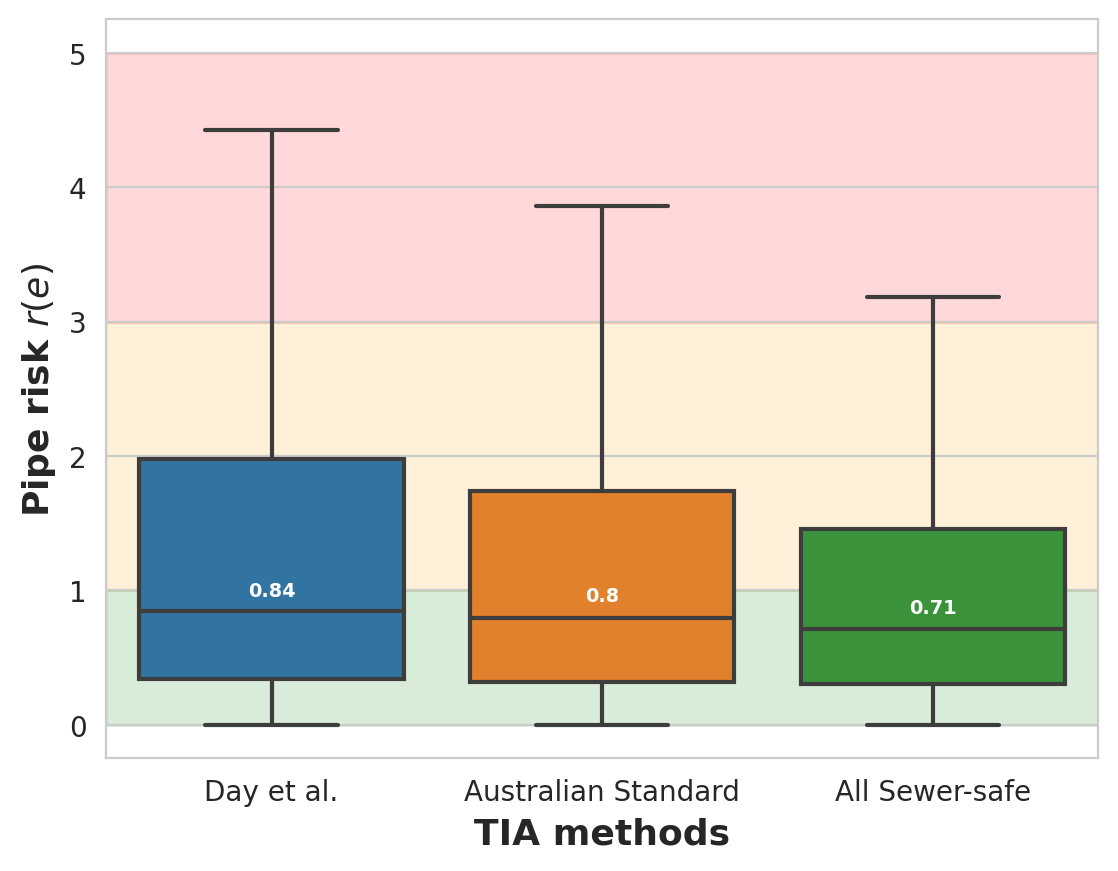

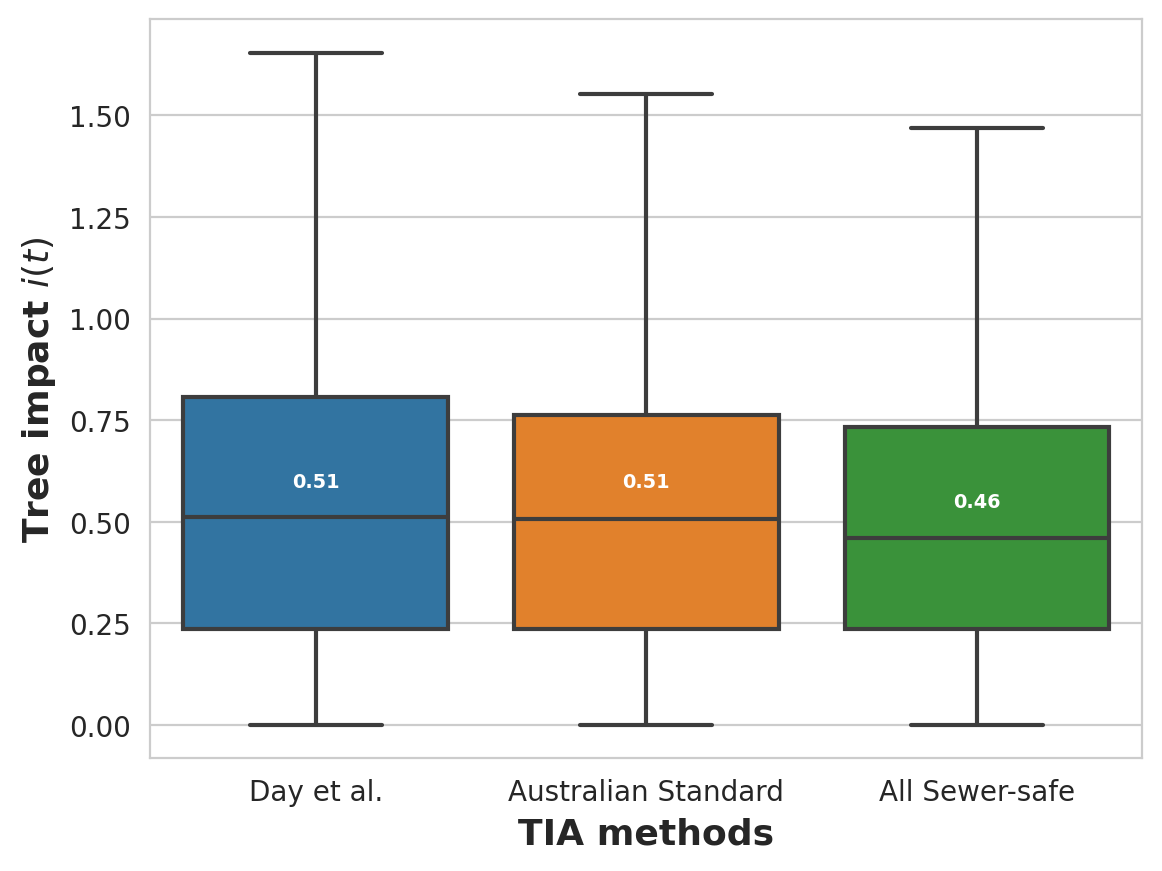

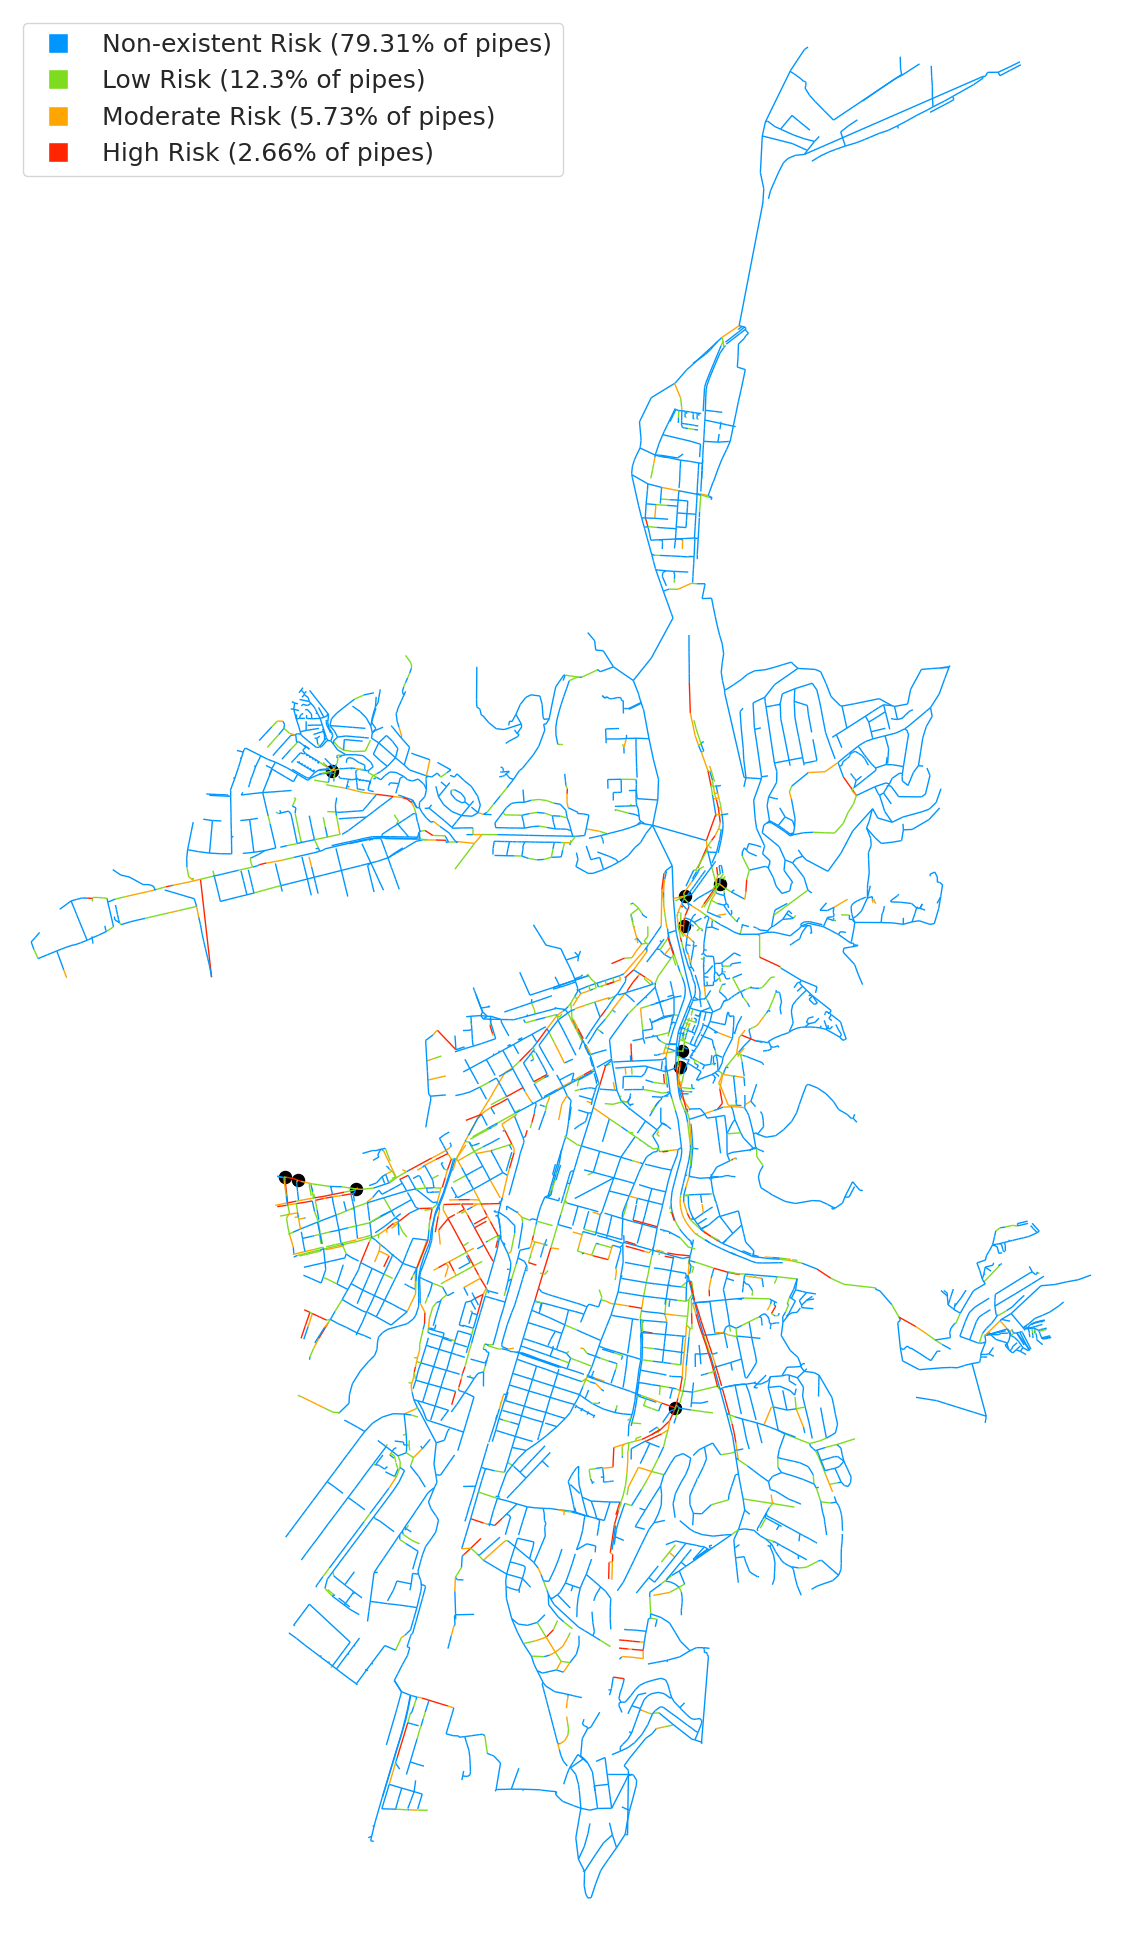

{'au_max': {0: 6585, 1: 1021, 2: 476, 3: 221}, 'min_max': {0: 7377, 1: 599, 2: 257, 3: 70}, 'lit_max': {0: 5812, 1: 1393, 2: 741, 3: 357}}
{'au_max': {0: 79.31, 1: 12.3, 2: 5.73, 3: 2.66}, 'min_max': {0: 88.85, 1: 7.21, 2: 3.1, 3: 0.84}, 'lit_max': {0: 70.0, 1: 16.78, 2: 8.92, 3: 4.3}}


In [17]:
# Once computations are completed, extract normalized risk value for each tree-pipe interaction and aggregate it.
pipe_risks, tree_risks, risk_data, risk_data_trees = compute_pipe_risk_tree_impact(graph_p, df, tree_pipes)

# For each method, get the ordered list of most impactfull trees.
tree_impact_index = {}
tree_impact_value = {}
tree_impact_geo = {}
for method in methods:
    ordered_tree_indexes = [key for key, value in sorted(tree_risks[method].items(), key=lambda x: (-x[1], x[0]))][:10]
    tree_impact_index[method] = ordered_tree_indexes
    tree_impact_value[method] = [value for key, value in sorted(tree_risks[method].items(), key=lambda x: (-x[1], x[0]))][:10]
    tree_impact_geo[method] = list((df.iloc[element]['lat'],df.iloc[element]['lon']) for element in ordered_tree_indexes)

# Visualize and store the results.
full_visualization(graph_aux, tree_impact_geo, tree_impact_value, pipe_risks, tree_risks, risk_data, risk_data_trees, 'def_risk')

Computing rearrangement analysis of 1644 (5%) trees with replant False, please wait...


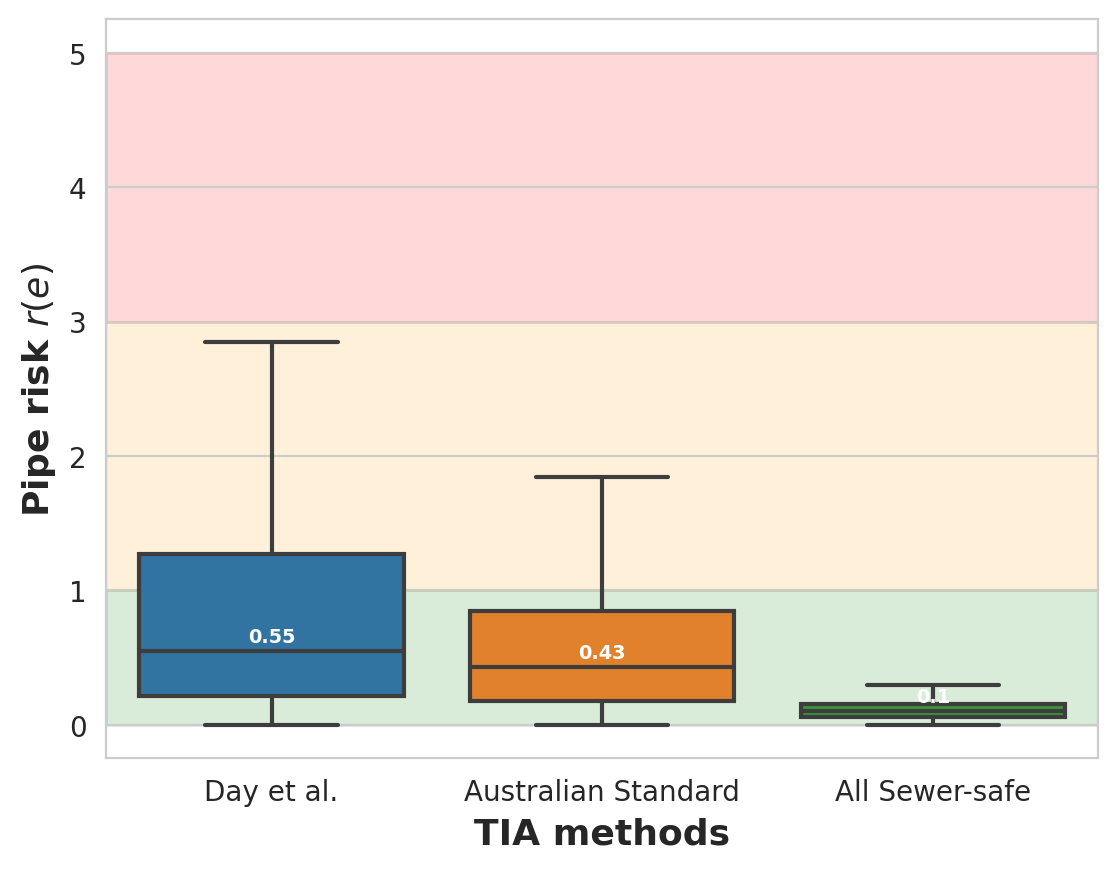

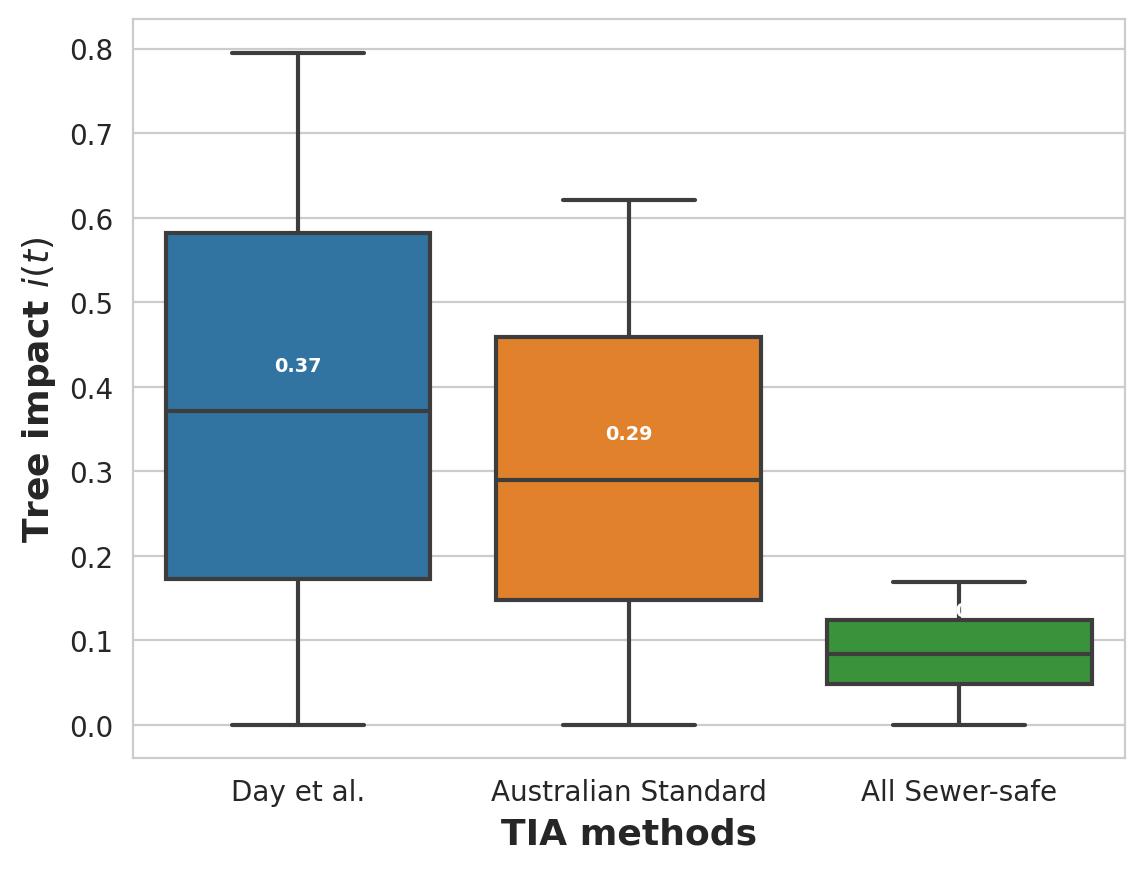

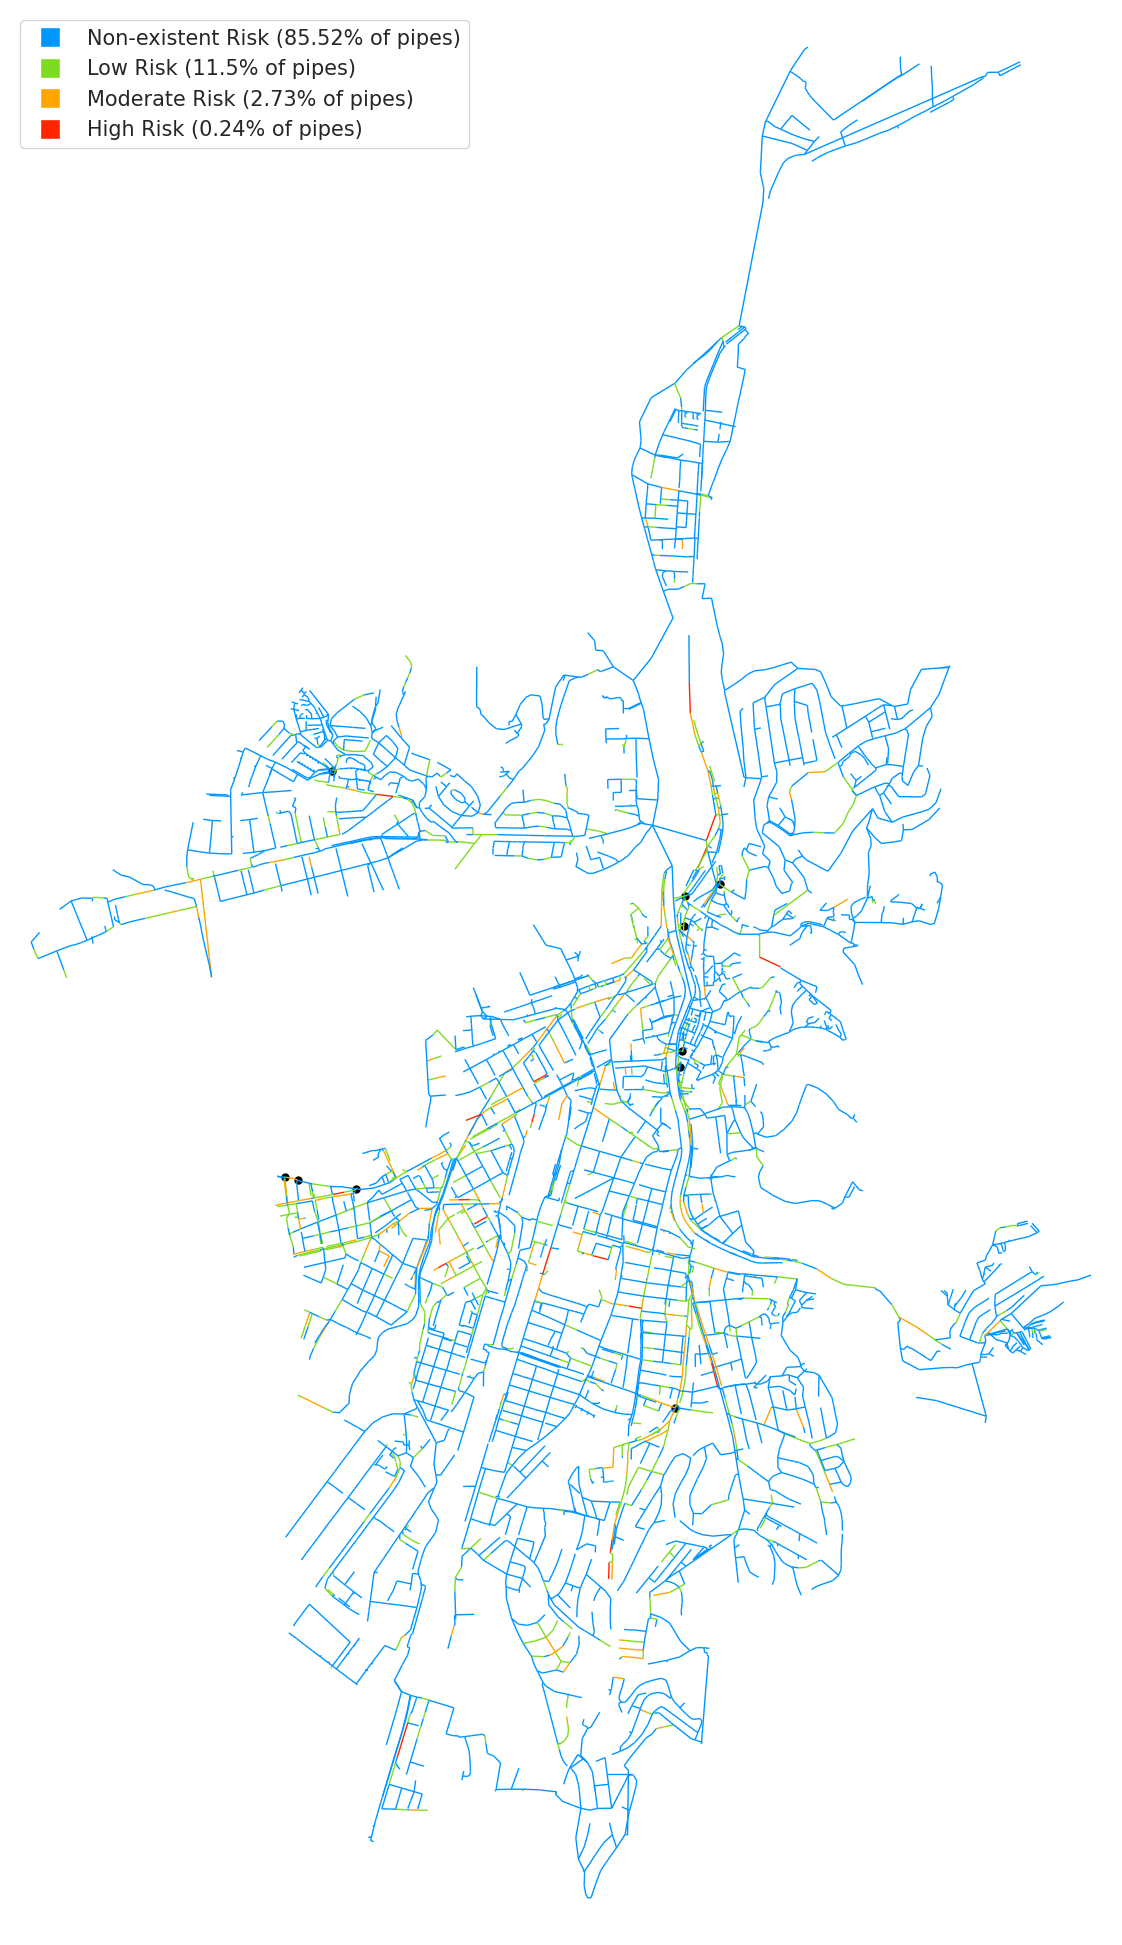

{'au_max': {0: 7101, 1: 955, 2: 227, 3: 20}, 'min_max': {0: 8036, 1: 267, 2: 0, 3: 0}, 'lit_max': {0: 6435, 1: 1289, 2: 469, 3: 110}}
{'au_max': {0: 85.52, 1: 11.5, 2: 2.73, 3: 0.24}, 'min_max': {0: 96.78, 1: 3.22, 2: 0.0, 3: 0.0}, 'lit_max': {0: 77.5, 1: 15.52, 2: 5.65, 3: 1.32}}
Computing rearrangement analysis of 1644 (5%) trees with replant True, please wait...


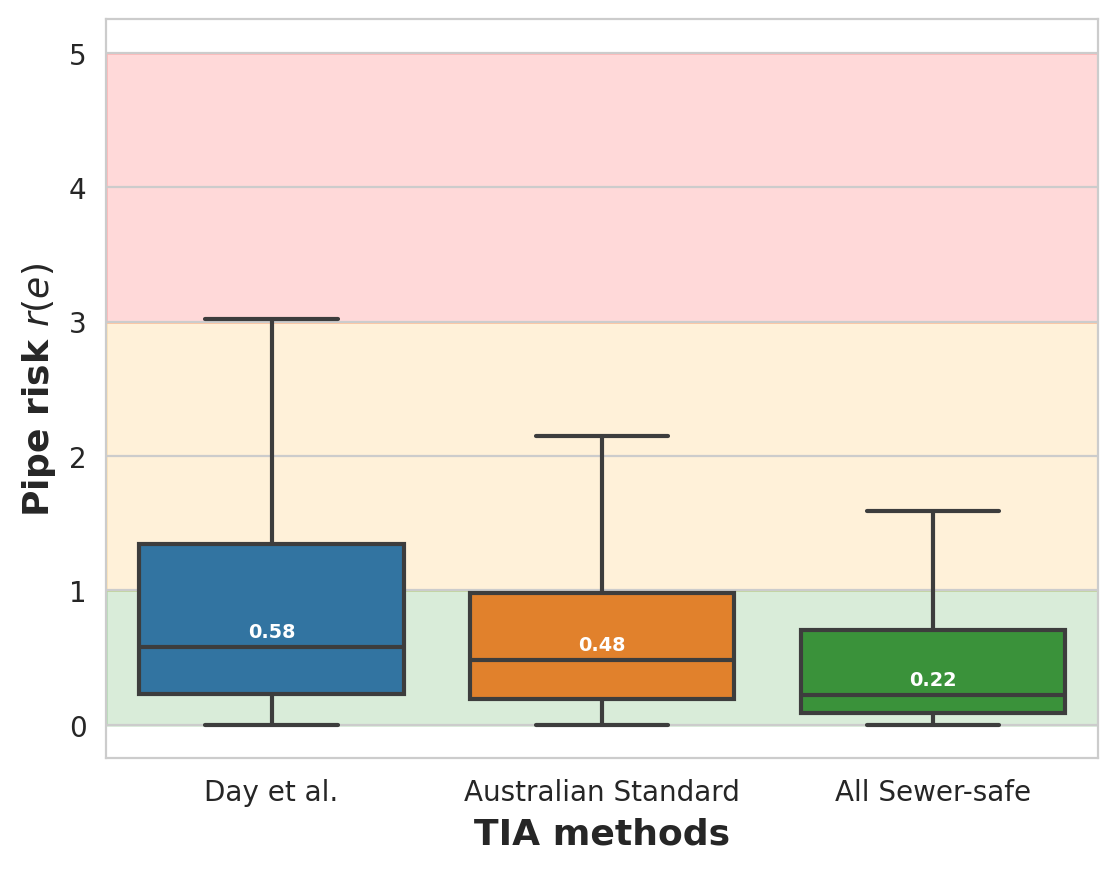

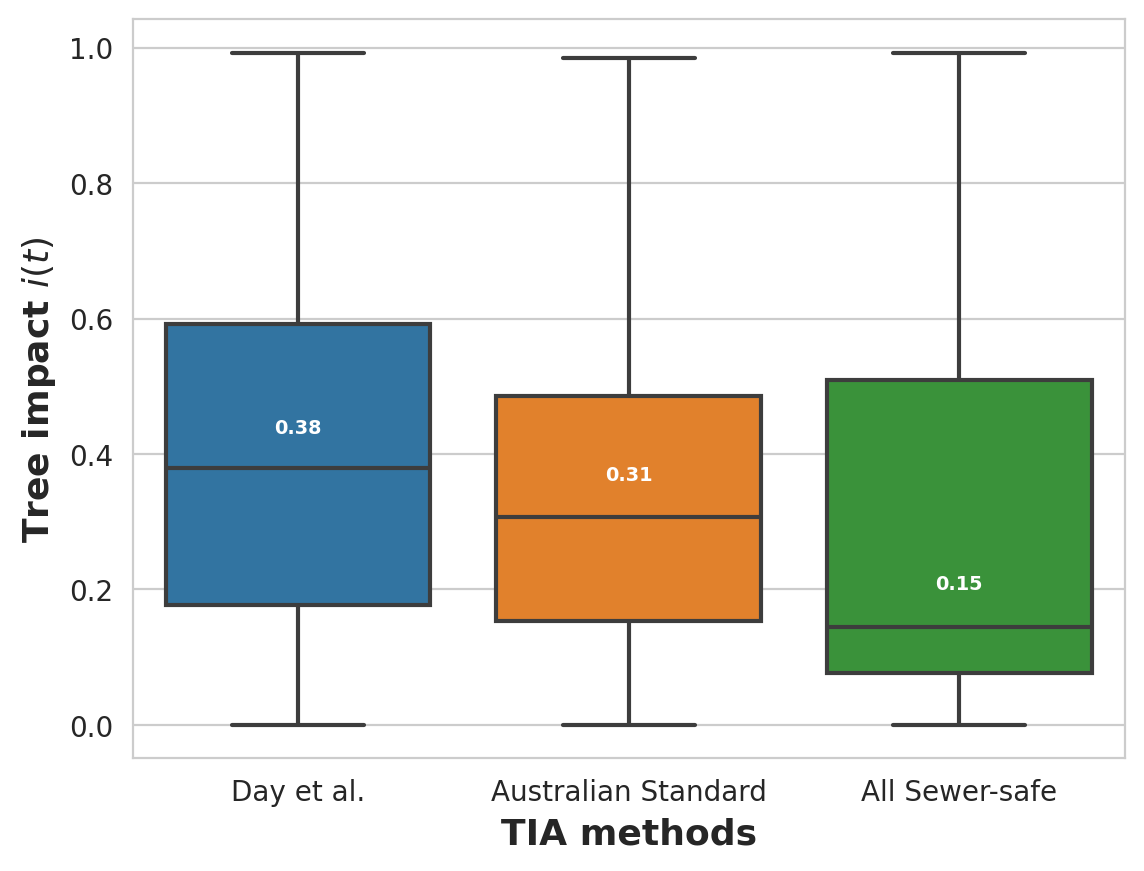

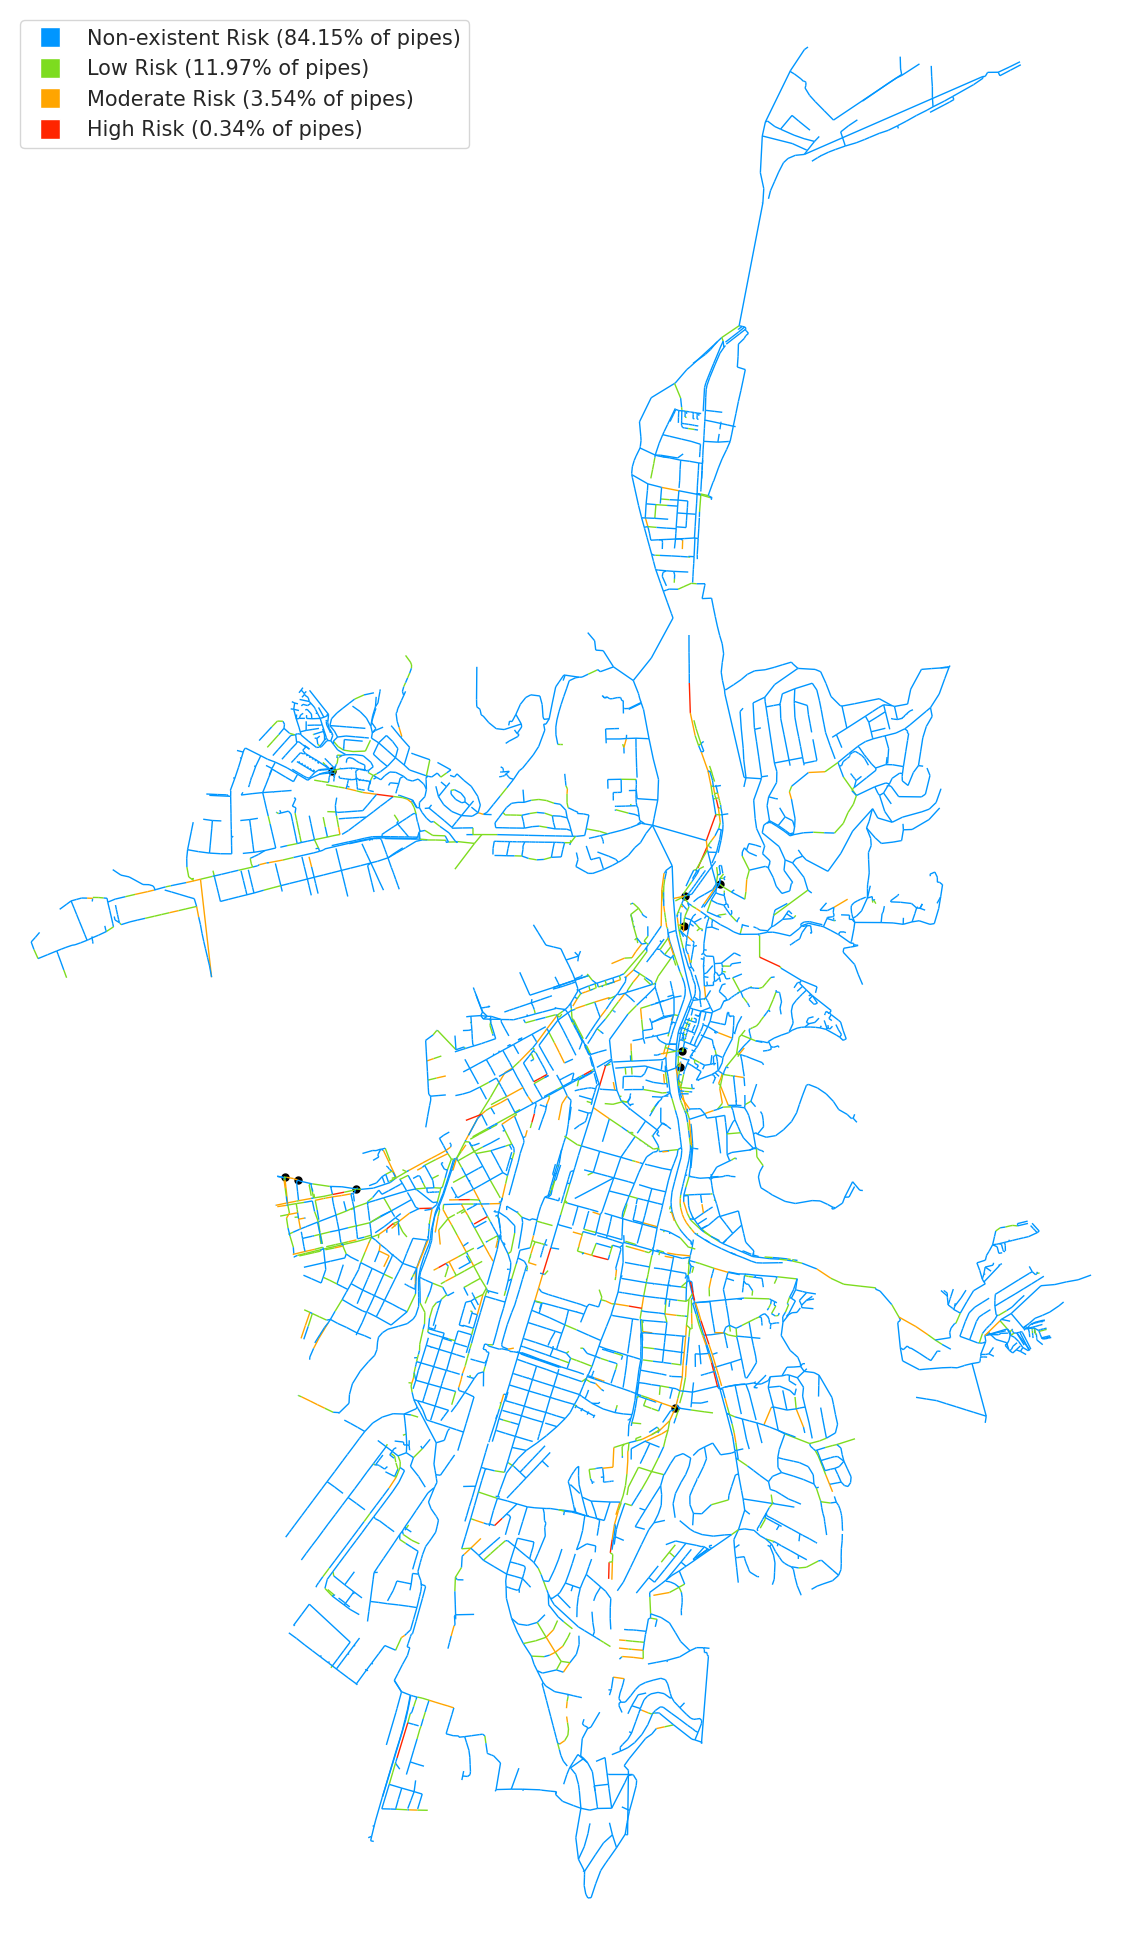

{'au_max': {0: 6987, 1: 994, 2: 294, 3: 28}, 'min_max': {0: 7832, 1: 413, 2: 54, 3: 4}, 'lit_max': {0: 6347, 1: 1320, 2: 502, 3: 134}}
{'au_max': {0: 84.15, 1: 11.97, 2: 3.54, 3: 0.34}, 'min_max': {0: 94.33, 1: 4.97, 2: 0.65, 3: 0.05}, 'lit_max': {0: 76.44, 1: 15.9, 2: 6.05, 3: 1.61}}


In [36]:
# Now, get an ordered list of tree IDs by tree impact for each method.
#  Then, we will try rearranging the top X% of trees, and analyze the effects on risk WITH & WITHOUT REPLACEMENT. Change the next two variables for algorithm customization.
percent = 5
replant_strategies = [False,True]

n_trees = len(df.index)
n_trees_percent = round(n_trees * percent / 100)

for replant in replant_strategies:
    print("Computing rearrangement analysis of "+str(n_trees_percent)+" ("+str(percent)+"%) trees with replant "+str(replant)+", please wait...")
    ordered_impacts = {}
    pipe_risks_aux = {}
    tree_risks_aux = {}
    risk_data_aux = {}
    risk_data_trees_aux = {}

    for method in methods:
        ordered_impacts[method] = [key for key, value in sorted(tree_risks[method].items(), key=lambda x: (-x[1], x[0]))]
        pipe_risks_aux_method, tree_risks_aux_method, risk_data_aux_method, risk_data_trees_aux_method = compute_pipe_risk_tree_impact(
            graph_p, df, tree_pipes, exclude_trees = ordered_impacts[method][:n_trees_percent], replant = replant)
        pipe_risks_aux[method] = pipe_risks_aux_method[method]
        tree_risks_aux[method] = tree_risks_aux_method[method]
        risk_data_aux[method] = risk_data_aux_method[method]
        risk_data_trees_aux[method] = risk_data_trees_aux_method[method]
    full_visualization(graph_aux, tree_impact_geo, tree_impact_value, pipe_risks_aux, tree_risks_aux, risk_data_aux, risk_data_trees_aux, filename="rearranged_replant_"+str(replant))


In [24]:
# Show the most impactful trees.
df2 = pd.DataFrame(df1, columns=['Scientific name', 'Trunk per. (cm)', 'Trunk diam. max. (cm)', 'TPZ A.S. (m)'])
df2["Tree impact i(t)"] = 0

for tree_index in ordered_impacts['au_max'][:10]:
    df2['Tree impact i(t)'][tree_index] = tree_risks['au_max'][tree_index]

df2.iloc[ordered_impacts['au_max'][:10]]

nom_cientific           Pinus pinea
nom                       Pi pinyer
mida_tronc                    20-50
mida_escocell                 sense
x                    4671823.679078
y                      314442.84082
lat                       41.967706
lon                        2.823545
old_x                   485378.9911
old_y                   4646205.742
max_tronc                 15.915494
tpz_au_max                 1.909859
tpz_min_max                 0.95493
tpz_lit_max                2.864789
nearest_edge                 e10910
nearest_edge_dist          0.047827
Name: 19463, dtype: object
None


/tmp/ipykernel_80928/276222178.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Tree impact i(t)'][tree_index] = tree_risks['au_max'][tree_index]


In [51]:
## Cost of repairs calculations.

n_trees = len(df.index)
percents = list(range(1,15))

risk_dict, risk_dict_percent, risk_edges, edge_risk = get_risk_dicts(graph, pipe_risks)

labels = []
labels.append('')
labels.append('Original')
data_plot_list = [['Low risk'],['Moderate risk'],['High risk']]
risk_data_array = []
risk_data_array.append(risk_data)
data_plot_list[0].append(risk_dict_percent['au_max'][1])
data_plot_list[1].append(risk_dict_percent['au_max'][2])
data_plot_list[2].append(risk_dict_percent['au_max'][3])
cost_pipe_repair_m = 230
repair_costs = []

# Get the upper bound value of aggregated pipe risks.
q3, q1 = np.percentile(np.array([i for i in pipe_risks['au_max'].values() if i != 0]), [75, 25])
IQR = q3 - q1
#upper_bound = q3 + 1.5 * IQR
upper_bound = 5

for percent in percents:

    n_trees_percent = round(n_trees * percent / 100)
    for replant in [True]:
        print("Computing rearrangement analysis of "+str(n_trees_percent)+" ("+str(percent)+"%) trees with replant "+str(replant)+", please wait...")
        ordered_impacts = {}
        pipe_risks_aux = {}
        tree_risks_aux = {}
        risk_data_aux = {}
        risk_data_trees_aux = {}

        for method in methods:
            ordered_impacts[method] = [key for key, value in sorted(tree_risks[method].items(), key=lambda x: (-x[1], x[0]))]
            pipe_risks_aux_method, tree_risks_aux_method, risk_data_aux_method, risk_data_trees_aux_method = compute_pipe_risk_tree_impact(
                graph_p, df, tree_pipes, exclude_trees = ordered_impacts[method][:n_trees_percent], replant = replant)
            pipe_risks_aux[method] = pipe_risks_aux_method[method]
            tree_risks_aux[method] = tree_risks_aux_method[method]
            risk_data_aux[method] = risk_data_aux_method[method]
            risk_data_trees_aux[method] = risk_data_trees_aux_method[method]
        risk_dict_aux, risk_dict_percent_aux, risk_edges_aux, edge_risk_aux = get_risk_dicts(graph, pipe_risks_aux)
        risk_data_array.append(risk_data_aux['au_max'])
        
        labels.append(str(percent)+'% rearrangement')
        data_plot_list[0].append(risk_dict_percent_aux['au_max'][1])
        data_plot_list[1].append(risk_dict_percent_aux['au_max'][2])
        data_plot_list[2].append(risk_dict_percent_aux['au_max'][3])
        
        # Pipe repair expected value.
        repair_cost = 0
        for pipe_id, risk in pipe_risks_aux['au_max'].items():
            if risk > 0:
                length = graph_p.get_edge_data(*pipe_ids[pipe_id])[0]['LENGTH']
                prob = risk/upper_bound
                repair_cost += prob * math.ceil(length) * cost_pipe_repair_m
        repair_costs.append(repair_cost)
        print(" - Repair costs:",repair_cost)
        
repair_cost = 0
for pipe_id, risk in pipe_risks['au_max'].items():
    if risk > 0:
        length = graph_p.get_edge_data(*pipe_ids[pipe_id])[0]['LENGTH']
        prob = risk/upper_bound
        repair_cost += prob * math.ceil(length) * cost_pipe_repair_m

repair_costs.insert(0, repair_cost)

Computing rearrangement analysis of 329 (1%) trees with replant True, please wait...
 - Repair costs: 4457352.306741536
Computing rearrangement analysis of 658 (2%) trees with replant True, please wait...
 - Repair costs: 4026391.435939958
Computing rearrangement analysis of 986 (3%) trees with replant True, please wait...
 - Repair costs: 3389156.5359680057
Computing rearrangement analysis of 1315 (4%) trees with replant True, please wait...
 - Repair costs: 2781669.068306454
Computing rearrangement analysis of 1644 (5%) trees with replant True, please wait...
 - Repair costs: 2287492.5941267186
Computing rearrangement analysis of 1973 (6%) trees with replant True, please wait...
 - Repair costs: 1837839.9336555738
Computing rearrangement analysis of 2302 (7%) trees with replant True, please wait...
 - Repair costs: 1463223.4901545164
Computing rearrangement analysis of 2630 (8%) trees with replant True, please wait...
 - Repair costs: 1146329.909018896
Computing rearrangement analysi

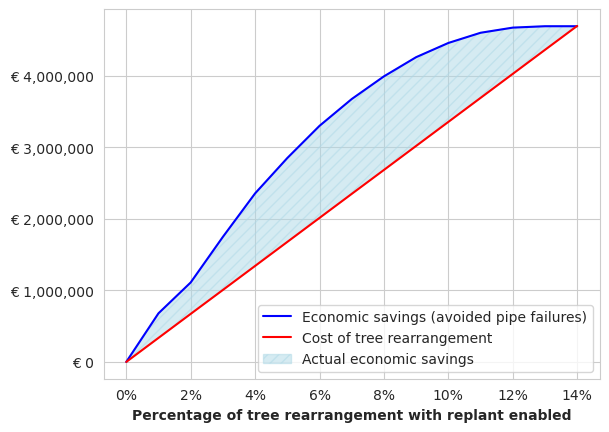

In [53]:
# plotting
plt.xlabel("Percentage of tree rearrangement (TR) with replant enabled",fontweight='bold')
#plt.ylabel("Expected cost of pipe failure repairs")
x = list(range(0,15))
tree_costs = [0, 335580, 671160, 1005720, 1341300, 1676880, 2012460, 2348040, 2682600, 3018180, 3353760, 3689340, 4024920, 4360500, 4695060]
estalvi = [repair_costs[0]-i for i in repair_costs]
#plt.plot(x, repair_costs, color ="red")
plt.plot(x, estalvi, color ="blue", label="Economic savings (avoided pipe failures)")
plt.plot(x, tree_costs, color ="red", label="Cost of tree rearrangement")
plt.fill_between(x, estalvi, tree_costs, hatch="///", color="lightblue", alpha=0.5, label="Actual economic savings")
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
plt.gca().yaxis.set_major_formatter('€ {x:1,.0f}')
plt.legend()
plt.savefig('./pdfs/img_results_costs.pdf', dpi=300,bbox_inches='tight')
plt.savefig('./pngs/img_results_costs.png', dpi=300,bbox_inches='tight')
plt.show()

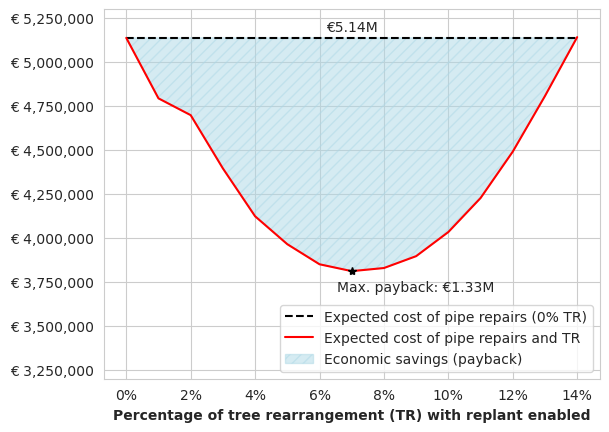

In [106]:
plt.xlabel("Percentage of tree rearrangement (TR) with replant enabled",fontweight='bold')
#plt.ylabel("Expected cost of pipe failure repairs")
x = list(range(0,15))
tree_costs = [0, 335580, 671160, 1005720, 1341300, 1676880, 2012460, 2348040, 2682600, 3018180, 3353760, 3689340, 4024920, 4360500, 4695060]
estalvi = [repair_costs[0]-i for i in repair_costs]
#plt.plot(x, repair_costs, color ="red")
plt.plot(x, np.full((15), repair_costs[0]), color='k', linestyle='dashed', label="Expected cost of pipe repairs (0% TR)")
#plt.plot(x, repair_costs, color ="blue", label="Expected cost of repairs")
#plt.plot(x, tree_costs, color ="red", label="Cost of tree rearrangement")
plt.plot(x, [x + y for x, y in zip(repair_costs, tree_costs)], color ="red", label="Expected cost of pipe repairs and TR")
plt.fill_between(x, np.full((15), repair_costs[0]), [x + y for x, y in zip(repair_costs, tree_costs)], hatch="///", color="lightblue", alpha=0.5, label="Economic savings (payback)")
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
plt.gca().yaxis.set_major_formatter('€ {x:1,.0f}')
plt.legend(loc='lower right')
ax = plt.gca()
ax.set_ylim([3200000, 5300000])
plt.text(7, 5200000, '€5.14M', ha='center', va='center',rotation='horizontal')
plt.plot(x[7],[x + y for x, y in zip(repair_costs, tree_costs)][7],'k*') 
plt.text(x[7]+2,[x + y for x, y in zip(repair_costs, tree_costs)][7]-90000, 'Max. payback: €1.33M', ha='center', va='center',rotation='horizontal')
plt.savefig('./pdfs/img_results_costs_v2.pdf', dpi=300,bbox_inches='tight')
plt.savefig('./pngs/img_results_costs_v2.png', dpi=300,bbox_inches='tight')
plt.show()

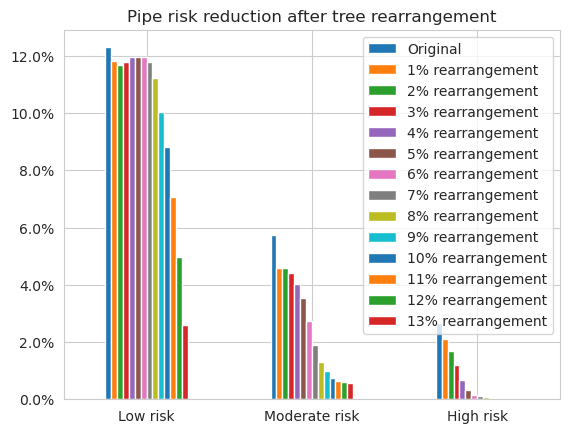

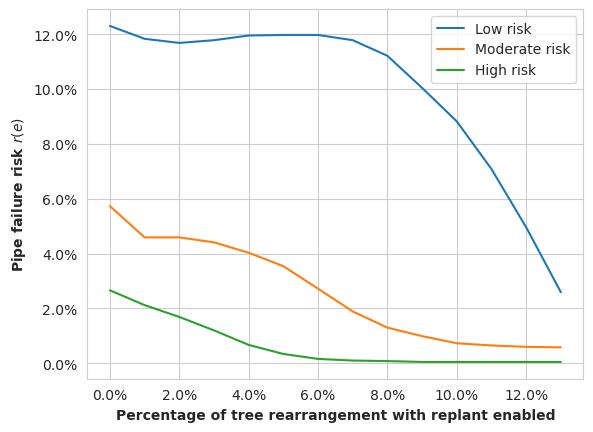

['High risk' 2.66 2.12 1.69 1.2 0.67 0.34 0.16 0.1 0.08 0.05 0.05 0.05
 0.05 0.05]
['Moderate risk' 5.73 4.59 4.59 4.41 4.03 3.54 2.72 1.89 1.3 0.99 0.73
 0.65 0.6 0.58]
['Low risk' 12.3 11.83 11.68 11.78 11.95 11.97 11.97 11.78 11.21 10.04
 8.82 7.08 4.96 2.59]


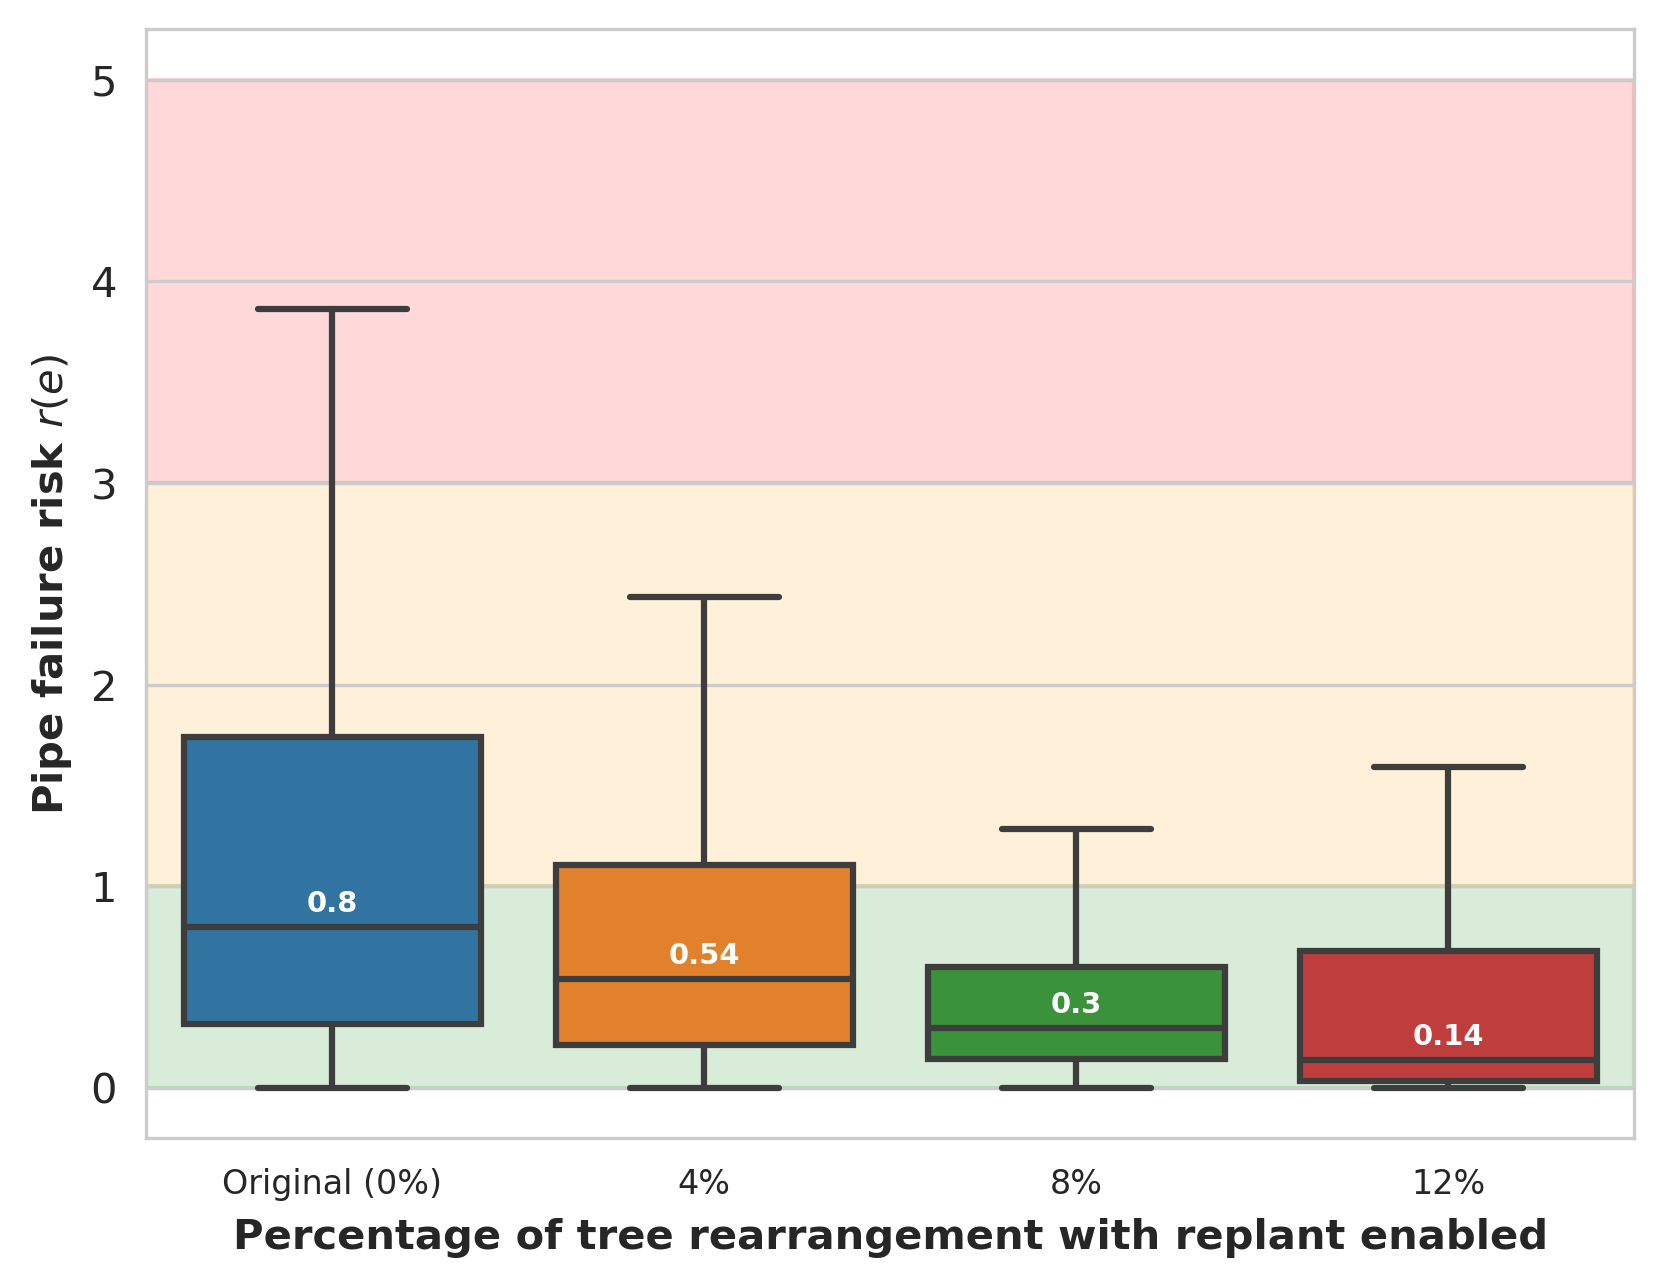

In [49]:
df_plot = pd.DataFrame(data_plot_list,columns=labels)
ax = df_plot.plot(kind='bar')
ax.set_xticklabels(['Low risk','Moderate risk','High risk'], rotation = 0)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_title('Pipe risk reduction after tree rearrangement')
plt.show()

array_df = df_plot.to_numpy()

df_test = pd.DataFrame({'Low risk': array_df[0][1:],
                   'Moderate risk': array_df[1][1:],
                   'High risk': array_df[2][1:]})

ax = df_test.plot()
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.xaxis.set_major_formatter(mtick.PercentFormatter())
#ax.set_title('Tree rearrangement (TR) algorithm risk reduction (A.S. method, with replant)')
plt.xlabel('Percentage of tree rearrangement with replant enabled',fontweight='bold')
plt.ylabel('Pipe failure risk $r(e)$',fontweight='bold')
plt.savefig('./pdfs/img_results_tr.pdf', dpi=300,bbox_inches='tight')
plt.show()

print(array_df[2])
print(array_df[1])
print(array_df[0])

# Visualize data.
boxplot_arr = []
value_np = np.array(risk_data_array[0]['au_max'])
boxplot_arr.append(value_np[value_np != 0].tolist())
value_np = np.array(risk_data_array[4])
boxplot_arr.append(value_np[value_np != 0].tolist())
value_np = np.array(risk_data_array[8])
boxplot_arr.append(value_np[value_np != 0].tolist())
value_np = np.array(risk_data_array[12])
boxplot_arr.append(value_np[value_np != 0].tolist())

plt.figure(dpi = 300) 
ax = sns.boxplot(data=boxplot_arr, showfliers = False)
ax.set_xticklabels(["Original (0%)","4%","8%","12%"])
plt.xticks(fontsize=8)
plt.xlabel('Percentage of tree rearrangement with replant enabled',fontweight='bold')
plt.ylabel('Pipe failure risk $r(e)$',fontweight='bold')
ax.axhspan(0, 1, alpha=0.15, color='green', zorder=0)
ax.axhspan(1, 3, alpha=0.15, color='orange', zorder=0)
ax.axhspan(3, 5, alpha=0.15, color='red', zorder=0)

medians = [round(np.median([el for el in sublist]),2) for sublist in boxplot_arr]
vertical_offset = np.median(sum(boxplot_arr, [])) * 0.15
for xtick in ax.get_xticks():
    ax.text(xtick,medians[xtick] + vertical_offset,medians[xtick], horizontalalignment='center',size='x-small',color='w',weight='semibold')

plt.savefig('./pngs/img_results_tr_hist.png', dpi=300)
plt.savefig('./pdfs/img_results_tr_hist.pdf', dpi=300,bbox_inches='tight')
plt.show()


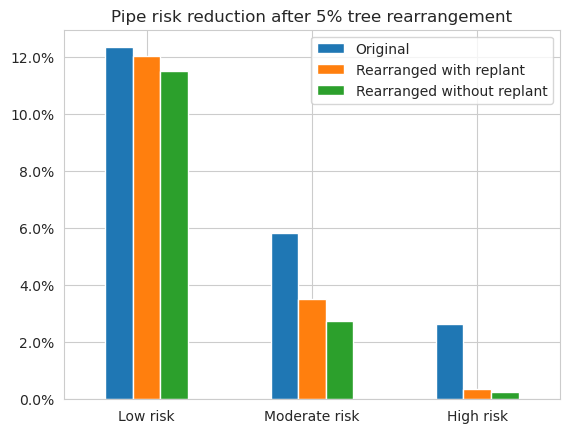

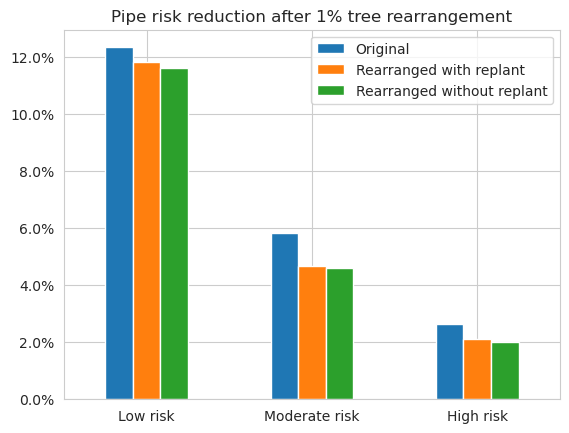

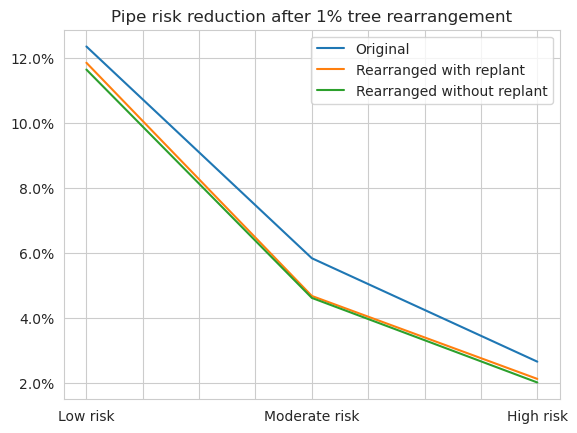

In [40]:
# Comparision between normal and rearranged values.
data_plot = {'Original': {'Low risk':12.34,'Moderate risk':5.83,'High risk':2.65}, 
        'Rearranged with replant': {'Low risk':12.04,'Moderate risk':3.52,'High risk':0.35},
        'Rearranged without replant': {'Low risk':11.5,'Moderate risk':2.73,'High risk':0.24}}

{'au_max': {0: 81.74, 1: 11.63, 2: 4.61, 3: 2.01}, 'min_max': {0: 90.39, 1: 6.9, 2: 2.37, 3: 0.34}, 'lit_max': {0: 72.2, 1: 16.86, 2: 7.43, 3: 3.5}}
{'au_max': {0: 81.37, 1: 11.84, 2: 4.67, 3: 2.12}, 'min_max': {0: 89.63, 1: 7.07, 2: 2.75, 3: 0.55}, 'lit_max': {0: 71.99, 1: 16.91, 2: 7.55, 3: 3.55}}

df_plot = pd.DataFrame(data_plot)

ax = df_plot.plot(kind='bar')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_xticklabels(['Low risk','Moderate risk','High risk'], rotation = 0)
ax.set_title('Pipe risk reduction after 5% tree rearrangement')
plt.savefig('./pdfs/rearrangement_bars.pdf', dpi=300)
plt.savefig('./pngs/rearrangement_bars.png', dpi=300)
plt.show()

data_plot = {'Original': {'Low risk':12.34,'Moderate risk':5.83,'High risk':2.65}, 
        'Rearranged with replant': {'Low risk':11.84,'Moderate risk':4.67,'High risk':2.12},
        'Rearranged without replant': {'Low risk':11.63,'Moderate risk':4.61,'High risk':2.01}}

df_plot = pd.DataFrame(data_plot)

ax = df_plot.plot(kind='bar')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_xticklabels(['Low risk','Moderate risk','High risk'], rotation = 0)
ax.set_title('Pipe risk reduction after 1% tree rearrangement')
plt.show()

ax = df_plot.plot()
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_title('Pipe risk reduction after 1% tree rearrangement')
plt.show()


In [61]:
# Store results in pickles.
with open('pickles/trees_dataframe.pkl', 'wb') as file:
    pickle.dump(df, file)
with open('pickles/tree_pipes.pkl', 'wb') as file:
    pickle.dump(tree_pipes, file)